# Physics-Informed Machine Learning
Timon Palm

## 1D Linear Pertubated Wave Equation

$$ \frac{\partial^2{u}}{\partial{t^2}} = \frac{\partial^2{u}}{\partial{x^2}} -3u, \quad x \in [0, \pi], \quad t \in [0,1]$$

with inital and boundary conditions:

$$u(x,0) = 0, \quad \frac{\partial{u}}{\partial{t}}\biggr|_{t=0} = 2 \cos(x), \quad u(0,t) = \sin(2t), \quad u(\pi, t) = -\sin(2t)$$

and exact solution:

$$u_{exact}(x,t) = \cos(x)\sin(2t)$$

In [34]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch

In [35]:
def exact_solution(x, t):
    return np.cos(x) * np.sin(2 * t)

In [36]:
def plot_function(U, X, T, title: str, sample_points: np.array=None):
    fig = plt.figure(figsize=(12, 6))
    plt.title(title)
    ax = fig.add_subplot(121)
    plt.xlabel("x")
    plt.ylabel("t")
    c = ax.pcolormesh(X, T, U, cmap="coolwarm")
    fig.colorbar(c, ax=ax)

    if sample_points is not None:
        ax.scatter(sample_points[:, 0], sample_points[:, 1], color="black", alpha=0.5, s=2)

    ax = fig.add_subplot(122, projection="3d")
    ax.plot_surface(X, T, U, cmap="coolwarm")
    ax.view_init(30, 30)

    plt.xlabel("x")
    plt.ylabel("t")

    plt.show()

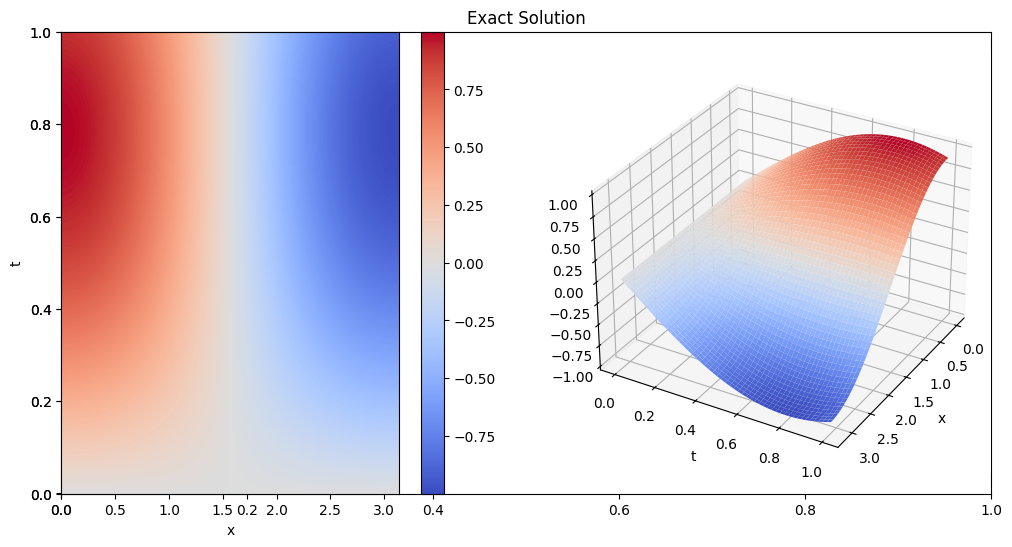

In [37]:
x = np.linspace(0, np.pi, 1000)
t = np.linspace(0, 1, 1000)

X, T = np.meshgrid(x, t)

U = exact_solution(X, T)

plot_function(U, X, T, "Exact Solution")

## Part A: Theory

### Explain how physics-informed neural networks (PINNs) can be used to solve the above PDE.

**What is the role of the neural network in this approach?**

We have the unknown solution $u(x,t)$, which is potentially a very complex function. In PINN, we utilize the efficacy of neural networks to approximate functions and use neural networks  as a surrogate for the unknown function $u(x,t) \approx NN(x,t;\Theta)$. Thus, the neural network is a function of $u$, $t$ and its adjustible weights $\Theta$. PDEs can involve partial derivatives or in this case second partial derivatives $\frac{\partial^2{u}}{\partial{t^2}}$ and $\frac{\partial^2{u}}{\partial{x^2}}$, which can be easily obtained by exploiding auto-differentiation as $u$ is the neural network.

**How are the PDE, inital conditions and boundary conditions incorporated into the loss functions?**

Typically, the loss of a PINN $\mathcal{L} = \mathcal{L}_p + \mathcal{L}_b$ consists of residual and boundary term. 

**Residual**: In the residual, the actual PDE or ODE is incorporated into the neural network to impose the model to adhere to the differential equation. For that, the PDE is formulated as:

$$0 = \frac{\partial^2{u}}{\partial{x^2}} -3u -\frac{\partial^2{u}}{\partial{t^2}}, \quad x \in [0, \pi], \quad t \in [0,1]$$

This should be minimized. Typically, deviations get penalized by the Mean Squared Error. This leads to the residual term:

$$\mathcal{L}_p = \| \frac{\partial^2{u}}{\partial{x^2}} -3u -\frac{\partial^2{u}}{\partial{t^2}} \|^2$$

**Boundary**: The boundary term of the PINN-loss ensures that the all boundary conditions are satisfied. In this case, there are two boundary conditions $u(0,t) = \sin(2t)$ and $u(\pi, t) = -\sin(2t)$. The model should output thses values for $x=0$ and $x=\pi$, respectively. Similar to the residual term, we use the Mean Squared error to keep the output $NN(x,t;\Theta)$ for $x=0$ and $x=\pi$ close to the desired values. This results in the loss function:

$$\mathcal{L}_b = \|NN(0,t;\Theta) - \sin(2t)\|^2 + \|NN(\pi,t;\Theta) + \sin(2t)\|^2$$

**Why are collocation points important in PINNs?**

<font color='red'>
    - collocation points discretize the function, it allows to have training trajectories \\
    - without collocation points we were only able to fit the inital and terminal condition \\
    - sampling is important
</font> 

### Discuss the advantages of using PINNs over traditional numerical methods (e.g. finite difference or finite element methods) and pure data-driven approaches (e.g., standard neural networks) for solving PDEs. Also, mention potential challenges of using PINNs.



Advantages:

<font color='red'>
        - mash-free \\
        - can jointly solve forward and inverse problems\\
        - often performs well on "messy" problems \\
        - tractable \\
        - mostly unsupervised
</font> 

Challenges;

<font color='red'>
    - high computational cost \\
    - can be challenging to optimize \\
    - difficault to scale to larger domains, multi-scale, multi-physics problems\\
    - difficult for high dimensional problems
</font>

## Part B: Implementation

1. **Design a neural network architecture suitable for solving this problem. Justify your choices (e.g. number of layers, input layer, output layer, number of neurons per layer, activation functions).**

In [38]:
from dataclasses import dataclass


@dataclass
class Data:
    x_initial: torch.Tensor
    t_initial: torch.Tensor

    x_residual: torch.Tensor
    t_residual: torch.Tensor

    x_boundary_1: torch.Tensor
    t_boundary_1: torch.Tensor

    x_boundary_2: torch.Tensor
    t_boundary_2: torch.Tensor


@dataclass
class Solution:
    initial: torch.Tensor
    residual: torch.Tensor
    boundary_1: torch.Tensor
    boundary_2: torch.Tensor

In [39]:
class PINN_model(torch.nn.Module):
    def __init__(self, n_layers, hidden_size):
        super(PINN_model, self).__init__()
        self.hidden_size = hidden_size

        self.in_layer = torch.nn.Linear(2, hidden_size)
        self.hidden_layers = [
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.Tanh(),
        ] * n_layers
        self.out_layer = torch.nn.Linear(hidden_size, 1)

        self.layers = torch.nn.Sequential(
            self.in_layer, torch.nn.Tanh(), *self.hidden_layers, self.out_layer
        )

    def forward(self, data: Data) -> Solution:

        len_initial = len(data.x_initial)
        len_residual = len(data.x_residual)
        len_boundary_1 = len(data.x_boundary_1)

        x = torch.cat(
            [data.x_initial, data.x_residual, data.x_boundary_1, data.x_boundary_2]
        ).unsqueeze(1)
        t = torch.cat(
            [data.t_initial, data.t_residual, data.t_boundary_1, data.t_boundary_2]
        ).unsqueeze(1)

        xt = torch.cat([x, t], dim=1)

        out = self.layers(xt).squeeze()

        res = Solution(
            initial=out[:len_initial],
            residual=out[len_initial : len_initial + len_residual],
            boundary_1=out[
                len_initial + len_residual : len_initial + len_residual + len_boundary_1
            ],
            boundary_2=out[len_initial + len_residual + len_boundary_1 :],
        )

        return res
    
    def predict(self, X, T):
        x = torch.tensor(X).float().unsqueeze(1)
        t = torch.tensor(T).float().unsqueeze(1)

        xt = torch.cat([x, t], dim=1)

        return self.layers(xt).squeeze().detach().numpy()

2. **Write the total loss function for this problem.**

In [40]:
def nn_loss(u: Solution, data: Data, ddx, ddt, dt):
    residual = torch.mean((ddx - 3 * u.residual - ddt) ** 2)

    boundary = torch.mean((u.boundary_1 - torch.sin(2 * data.t_boundary_1)) ** 2) + torch.mean(
        (u.boundary_2 + torch.sin(2 * data.t_boundary_2)) ** 2
    )

    initial = torch.mean(u.initial ** 2) + torch.mean((dt - 2 * torch.cos(data.x_initial))**2)

    return residual + boundary + initial, residual, boundary, initial

3. **Outline the training loop for the PINN.**

In [41]:
def train(model: PINN_model, data: Data, epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses = {
        "loss": [],
        "residual": [],
        "boundary": [],
        "initial": [],
    }
    for epoch in range(epochs):
        optimizer.zero_grad()

        u = model(data)

        sol = u.residual
        x = data.x_residual
        t = data.t_residual

        # calculate second derivative w.r.t. x
        dx = torch.autograd.grad(
            sol, x, grad_outputs=torch.ones_like(sol), create_graph=True
        )[0]
        ddx = torch.autograd.grad(
            dx, x, grad_outputs=torch.ones_like(sol), create_graph=True
        )[0]

        # calculate second derivative w.r.t. t
        dt = torch.autograd.grad(
            sol, t, grad_outputs=torch.ones_like(t), create_graph=True
        )[0]
        ddt = torch.autograd.grad(
            dt, t, grad_outputs=torch.ones_like(t), create_graph=True
        )[0]

        dt_initial = torch.autograd.grad(
            u.initial, data.t_initial, grad_outputs=torch.ones_like(data.t_initial), create_graph=True
        )[0]

        # calculate loss
        loss, loss_r, loss_b, loss_i = nn_loss(u, data, ddx, ddt, dt_initial)

        loss.backward()

        optimizer.step()
        
        losses["loss"].append(loss.item())
        losses["residual"].append(loss_r.item())
        losses["boundary"].append(loss_b.item())
        losses["initial"].append(loss_i.item())

        

        print(f"Epoch {epoch}, Loss: {loss.item()}, Residual: {loss_r.item()}, Boundary: {loss_b.item()}")

    return losses

4. **Train**

In [42]:
def generate_data(n):
    data = Data(
        x_initial=torch.rand(n) * torch.pi,
        t_initial=torch.zeros(n, requires_grad=True),
        x_residual=(torch.rand(n) * torch.pi).requires_grad_(),
        t_residual=torch.rand(n, requires_grad=True),
        x_boundary_1=torch.zeros(n),
        t_boundary_1=torch.rand(n),
        x_boundary_2=torch.ones(n) * torch.pi,
        t_boundary_2=torch.rand(n),
    )
    return data

Epoch 0, Loss: 3.1569297313690186, Residual: 0.00900123082101345, Boundary: 1.1920061111450195
Epoch 1, Loss: 3.1205148696899414, Residual: 0.00037756000529043376, Boundary: 1.1660068035125732
Epoch 2, Loss: 3.0971524715423584, Residual: 0.0026895180344581604, Boundary: 1.1418583393096924
Epoch 3, Loss: 3.076958179473877, Residual: 0.008177343755960464, Boundary: 1.1183514595031738
Epoch 4, Loss: 3.053877353668213, Residual: 0.012076904997229576, Boundary: 1.0946543216705322
Epoch 5, Loss: 3.026799201965332, Residual: 0.013806232251226902, Boundary: 1.070266604423523
Epoch 6, Loss: 2.9964919090270996, Residual: 0.014529544860124588, Boundary: 1.0446789264678955
Epoch 7, Loss: 2.9639503955841064, Residual: 0.015814311802387238, Boundary: 1.0171983242034912
Epoch 8, Loss: 2.9297287464141846, Residual: 0.019015144556760788, Boundary: 0.9869382381439209
Epoch 9, Loss: 2.893785238265991, Residual: 0.02506967820227146, Boundary: 0.9528785943984985
Epoch 10, Loss: 2.855778932571411, Residual:

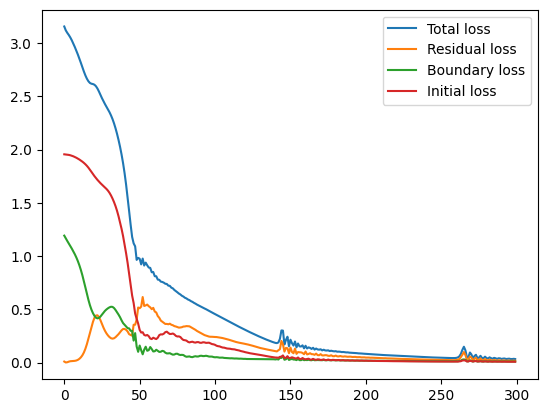

In [43]:
data = generate_data(1000)

model = PINN_model(n_layers=5, hidden_size=50)
losses = train(model, data, epochs=300)

# plot the loss
plt.plot(losses["loss"], label="Total loss")
plt.plot(losses["residual"], label="Residual loss")
plt.plot(losses["boundary"], label="Boundary loss")
plt.plot(losses["initial"], label="Initial loss")
plt.legend()
plt.show()

# Part C: Validation and Error Analysis

1. **Suppose you have trained the PINN and obtain a solution $u_{PINN}(x,t)$. Validate the solution by comparing it with the exact solution $u_{exact}(x,t)$.**

In [44]:
def plot_comparison():
    x = np.linspace(0, np.pi, 1000)
    t = np.linspace(0, 1, 1000)

    X, T = np.meshgrid(x, t)

    U = exact_solution(X, T)
    U_pred = model.predict(X.flatten(), T.flatten()).reshape(X.shape)

    plot_function(U, X, T, "Exact Solution")
    plot_function(U_pred, X, T, "Predicted Solution")

    diff = np.abs(U - U_pred)

    x = torch.cat(
        [data.x_initial, data.x_residual, data.x_boundary_1, data.x_boundary_2]
    ).unsqueeze(1).detach().numpy()
    t = torch.cat(
        [data.t_initial, data.t_residual, data.t_boundary_1, data.t_boundary_2]
    ).unsqueeze(1).detach().numpy()

    p = np.concat([x, t], axis=1)    

    plot_function(diff, X, T, "Difference", sample_points=p)

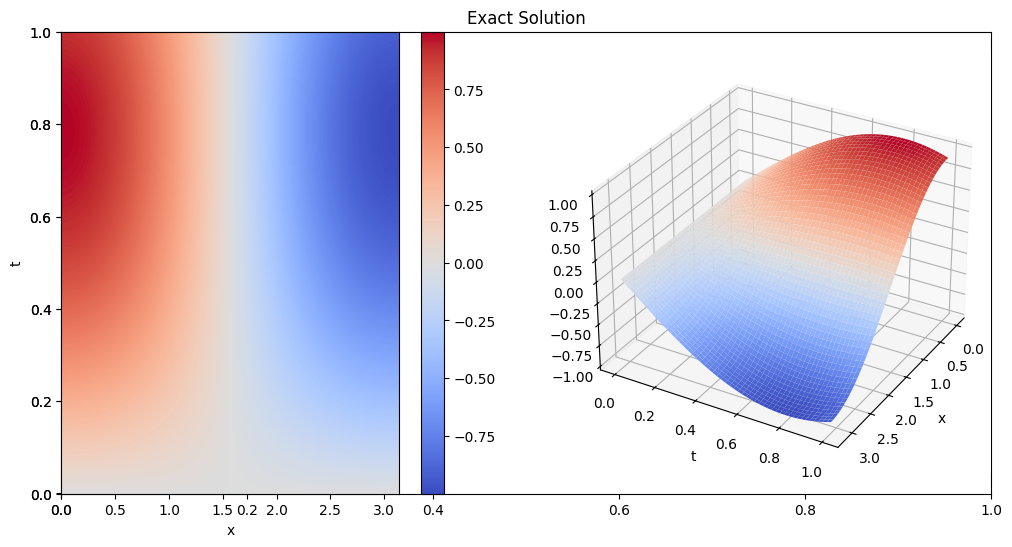

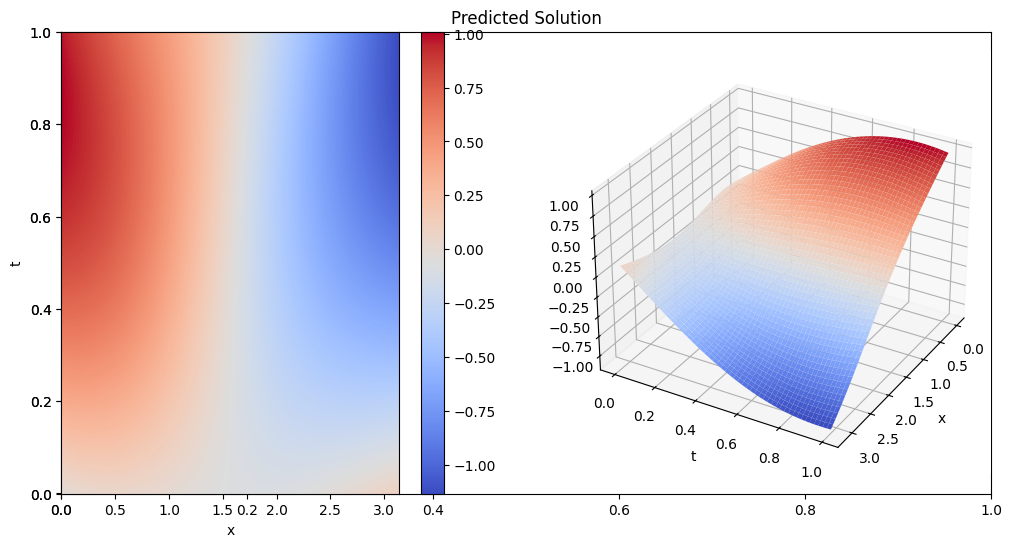

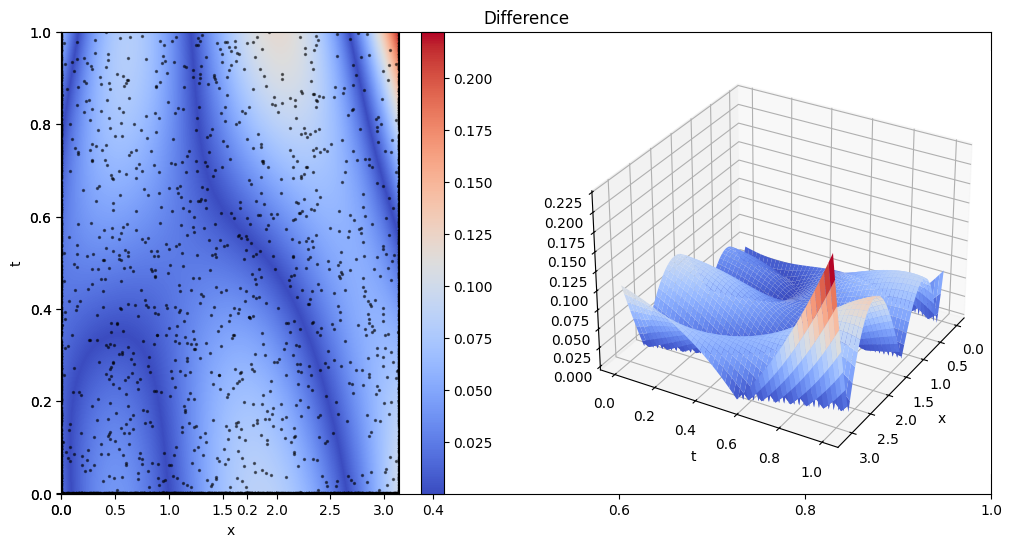

In [45]:
plot_comparison()

2. **If the PDE residual $\biggr| \frac{\partial^2 u}{\partial t^2} - \frac{\partial^2 u}{\partial x^2} + 3u \biggr|$ is large at certain points in the domain, what could be the reason? Suggest two strategies to improve the solution.**

In [46]:
# x = np.linspace(0, np.pi, 1000)
# t = np.linspace(0, 1, 1000)

# X, T = np.meshgrid(x, t)

# data = Data(
#         x_initial=torch.zeros(1),
#         t_initial=torch.zeros(1),
#         x_residual=torch.tensor(X.flatten(), requires_grad=True, dtype=torch.float32),
#         t_residual=torch.tensor(T.flatten(), requires_grad=True, dtype=torch.float32),
#         x_boundary_1=torch.zeros(1),
#         t_boundary_1=torch.zeros(1),
#         x_boundary_2=torch.ones(1),
#         t_boundary_2=torch.rand(1),
#     )

# u = model(data)

# sol = u.residual
# x = data.x_residual
# t = data.t_residual

# # calculate second derivative w.r.t. x
# dx = torch.autograd.grad(
#     sol, x, grad_outputs=torch.ones_like(sol), create_graph=True
# )[0]
# ddx = torch.autograd.grad(
#     dx, x, grad_outputs=torch.ones_like(sol), create_graph=True
# )[0]

# # calculate second derivative w.r.t. t
# dt = torch.autograd.grad(
#     sol, t, grad_outputs=torch.ones_like(t), create_graph=True
# )[0]
# ddt = torch.autograd.grad(
#     dt, t, grad_outputs=torch.ones_like(t), create_graph=True
# )[0]

# loss_r = torch.abs(ddx - 3 * u.residual - ddt)

# # plot residual loss on the grid
# plt.pcolormesh(X, T, loss_r.detach().numpy().reshape(X.shape), cmap="coolwarm")
# plt.xlabel("x")
# plt.ylabel("t")
# plt.title("Residual Loss")
# plt.colorbar()
# plt.show()
